In [1]:
import mat73
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.BatchNormalization()(c)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.BatchNormalization()(c)
    return c

In [3]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((400, 400, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    #outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model



In [4]:
rmsprop = tf.keras.optimizers.RMSprop(
        learning_rate=0.001,
        momentum=0.9,
        epsilon=1e-08
    )

loss = tf.keras.losses.mse

model = UNet()
model.compile(optimizer = rmsprop, loss = loss, metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
X_new = mat73.loadmat('X.mat')
Y_new = mat73.loadmat('Y.mat')

X_new = np.array(X_new['X'])
Y_new = np.array(Y_new['Y'])

scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()

X = np.ndarray((2250,400,400))
Y = np.ndarray((2250,400,400))

for i in range(X_new.shape[2]):
    
    
    #X[i,:,:] = 20*np.log10(np.abs(X_new[:,:,i]))
    #Y[i,:,:] = 20*np.log10(np.abs(Y_new[:,:,i]))
    
    #X[i,:,:] = preprocessing.normalize(X_new[:,:,i])
    #Y[i,:,:] = preprocessing.normalize(Y_new[:,:,i])
    
    scaler_X.fit(X_new[:,:,i])
    scaler_Y.fit(Y_new[:,:,i])
    
    X[i,:,:] = scaler_X.transform(X_new[:,:,i])
    Y[i,:,:] = scaler_Y.transform(Y_new[:,:,i])
    #x = X_new[:,:,i]
    #y = Y_new[:,:,i]
    
    #x[x < 0] = 0
    #y[y < 0] = 0
    
    #X[i,:,:] = x
    #Y[i,:,:] = y
    
X = np.expand_dims(X,axis=3)
Y = np.expand_dims(Y,axis=3)
print(np.shape(X))
print(np.shape(Y))

(2250, 400, 400, 1)
(2250, 400, 400, 1)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(f'X_train, X_test, y_train, y_test = {len(X_train)}, {len(X_test)},{len(y_train)},{len(y_test)}')

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(f'X_train, X_val, X_test, y_train,y_val, y_test = {X_train.shape}, {X_val.shape}, {X_test.shape},{y_train.shape},{y_val.shape},{y_test.shape}')




X_train, X_test, y_train, y_test = 1800, 450,1800,450
X_train, X_val, X_test, y_train,y_val, y_test = (1800, 400, 400, 1), (225, 400, 400, 1), (225, 400, 400, 1),(1800, 400, 400, 1),(225, 400, 400, 1),(225, 400, 400, 1)


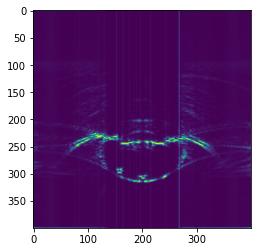

In [7]:
plt.imshow(X_train[40,:,:,:])

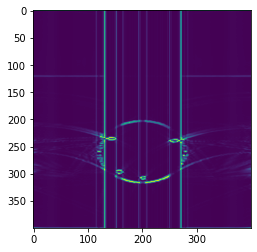

In [8]:
plt.imshow(y_train[40,:,:,:])

In [9]:
epochs = 50
batch_size = 20


history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val))

Epoch 1/50
90/90 [==============================] - 82s 688ms/step - loss: 0.0271 - acc: 0.0031 - val_loss: 0.0094 - val_acc: 0.0025
Epoch 2/50
90/90 [==============================] - 61s 683ms/step - loss: 0.0059 - acc: 0.0034 - val_loss: 0.3958 - val_acc: 0.0024
Epoch 3/50
90/90 [==============================] - 63s 703ms/step - loss: 0.0051 - acc: 0.0035 - val_loss: 0.0375 - val_acc: 0.0025
Epoch 4/50
90/90 [==============================] - 64s 717ms/step - loss: 0.0047 - acc: 0.0036 - val_loss: 0.0103 - val_acc: 0.0025
Epoch 5/50
90/90 [==============================] - 65s 720ms/step - loss: 0.0045 - acc: 0.0037 - val_loss: 0.0117 - val_acc: 0.0025
Epoch 6/50
90/90 [==============================] - 65s 725ms/step - loss: 0.0044 - acc: 0.0037 - val_loss: 0.0116 - val_acc: 0.0025
Epoch 7/50
90/90 [==============================] - 65s 725ms/step - loss: 0.0041 - acc: 0.0037 - val_loss: 0.0082 - val_acc: 0.0028
Epoch 8/50
90/90 [==============================] - 65s 719ms/step - 

In [10]:
model.save("UNet_Final_testv3_nl_minmax.h5")

In [11]:
model.load_weights("UNet_Final_testv3_nl_minmax.h5")

loss, acc = model.evaluate(X_test, y_test, verbose=2)

np.shape(X_test)

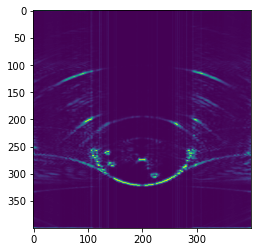

In [12]:
plt.imshow(X_train[1000,:,:,:])

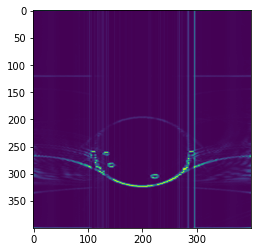

In [13]:
plt.imshow(y_train[1000,:,:,:])

In [14]:
output = model.predict(X_test)

In [15]:
output.shape

(225, 400, 400, 1)

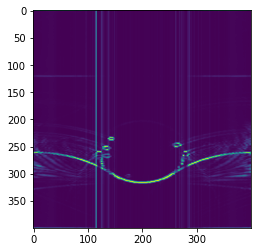

In [17]:
plt.imshow(y_test[10,:,:,:])

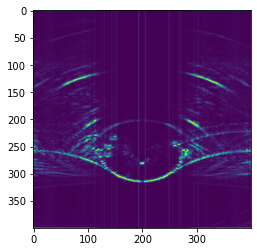

In [18]:
plt.imshow(X_test[10,:,:,:])

<ipython-input-20-3adac2b22001>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(output[10,:,:,:])))


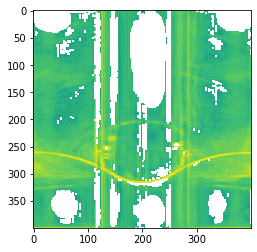

In [20]:
plt.imshow(20*np.log10(np.abs(output[10,:,:,:])))

In [24]:

result = np.where(y_test[10,:,:,:] > 0.0000000001, y_test[10,:,:,:], -10)

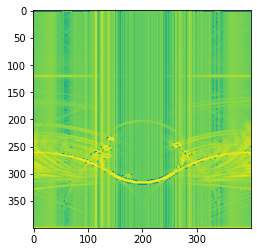

In [25]:
plt.imshow(20*np.log10(np.abs(y_test[10,:,:,:]), out=result,where=result>0))